# Classification Problem on Urban Tree Dataset

## PreProcessing

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

In [2]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [3]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [4]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [5]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quartier                   709 non-null    object 
 1   site                       709 non-null    object 
 2   cote_voirie                709 non-null    object 
 3   contrainte                 709 non-null    object 
 4   genre_arbre                709 non-null    object 
 5   espece_arbre               709 non-null    object 
 6   situation                  709 non-null    object 
 7   type_sol                   709 non-null    object 
 8   plaie_houppier             709 non-null    object 
 9   bois_mort_houppier         709 non-null    object 
 10  classe_age                 709 non-null    object 
 11  ecorce_incluse_houppier    709 non-null    object 
 12  classe_hauteur             709 non-null    object 
 13  fissure_houppier           709 non-null    object 

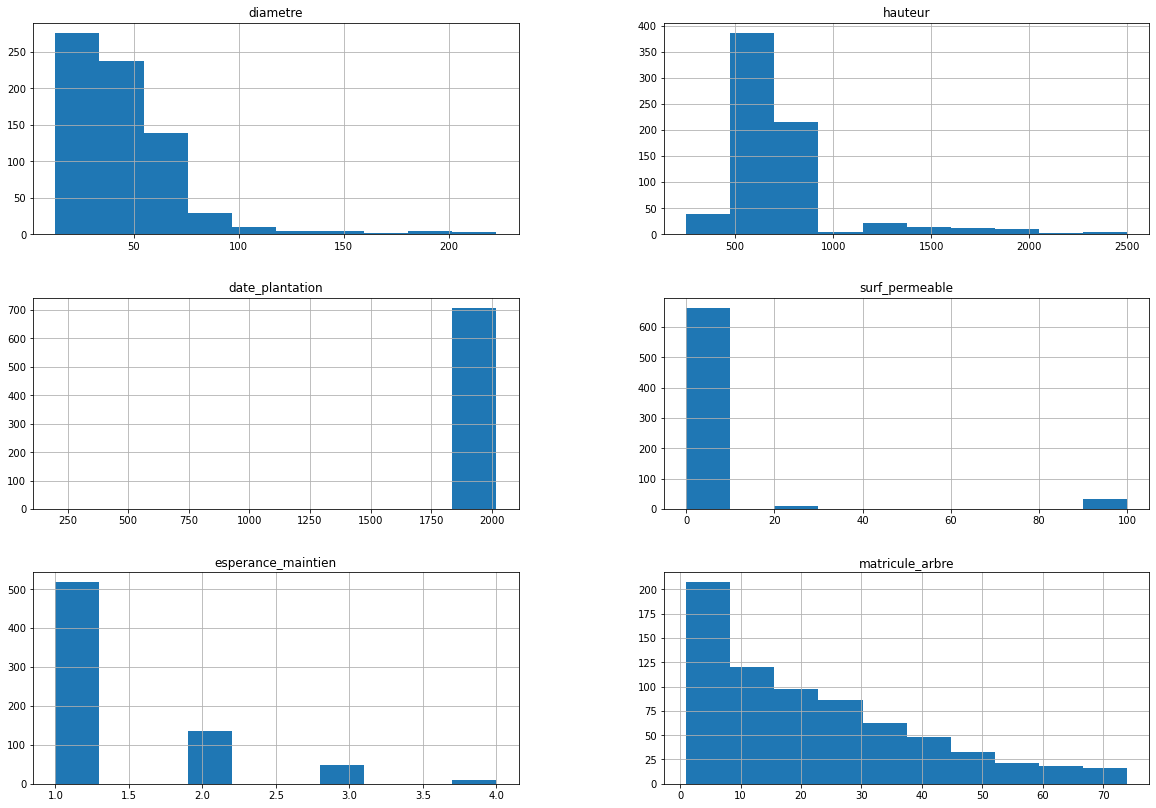

In [6]:
_ = df.hist(figsize=(20, 14))

In [7]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [8]:
df.nunique()

quartier                      6
site                         30
cote_voirie                   2
contrainte                    2
genre_arbre                  26
espece_arbre                 37
situation                     4
type_sol                      9
plaie_houppier                5
bois_mort_houppier            3
classe_age                    4
ecorce_incluse_houppier       2
classe_hauteur                5
fissure_houppier              3
classe_circonference          7
port_arbre                    5
vigueur_pousse                4
champignon_collet             2
plaie_collet                  7
champignon_tronc              2
fissure_tronc                 3
rejet_tronc                   2
tuteurage_arbre               4
canisse_arbre                 2
plaie_tronc                   6
champignon_houppier           2
diametre                     42
hauteur                      17
date_plantation              13
surf_permeable                9
esperance_maintien            4
matricul

In [9]:
df['classification_diagnostic'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: classification_diagnostic, dtype: int64

In [10]:
target_name = "classification_diagnostic"
target = df[target_name]
data = df.drop(columns=[target_name])

## AdaBoost

In [11]:
X = data.iloc[:].values
y = target.iloc[:].values

In [12]:
ct = ColumnTransformer(transformers=[('encoder', OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                unknown_value=-1), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [13]:
X

array([[1.0, 5.0, 0.0, ..., 5.0, 1.0, 7],
       [1.0, 5.0, 0.0, ..., 5.0, 1.0, 8],
       [1.0, 5.0, 0.0, ..., 5.0, 1.0, 9],
       ...,
       [0.0, 11.0, 0.0, ..., 1.0, 1.0, 6],
       [0.0, 11.0, 0.0, ..., 1.0, 2.0, 7],
       [0.0, 11.0, 0.0, ..., 1.0, 1.0, 8]], dtype=object)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [16]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [17]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [18]:
type(X)

numpy.ndarray

In [19]:
type(y)

numpy.ndarray

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

%%time
results_ab=[]
for i in range (1, 16, 1):
    base_estimator = DecisionTreeClassifier(max_depth=i, criterion='entropy', random_state=0)
    classifier = AdaBoostClassifier(n_estimators=1000, base_estimator= base_estimator, algorithm= "SAMME", random_state=0)
    classifier.fit(X_train, y_train)
    #y_pred = classifier.predict(X_test)
    #accuracy_score(y_test, y_pred)
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, 
                                 cv = 7, n_jobs=14)
    results_ab.append(accuracies)
    print(accuracies)

fig = plt.figure(figsize=(7,7))
fig.suptitle('Tree Depth Estimation using Validation results for AdaBoost')
plt.xlabel("Depth of the base estimator for Adaptive Boosting")
#ax = fig.add_subplot(1, 1, 1)
plt.boxplot(results_ab)
plt.ylabel("Test Accuracy Score")
#ax.set_xticklabels([])
plt.show()

In [23]:
%%time
results_ab=[]
for i in range (1, 16, 1):
    base_estimator = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=i+1, criterion='entropy', random_state=0)
    classifier = AdaBoostClassifier(n_estimators=1000, base_estimator= base_estimator, algorithm= "SAMME", random_state=0)
    classifier.fit(X_train, y_train)
    #y_pred = classifier.predict(X_test)
    #accuracy_score(y_test, y_pred)
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, 
                                 cv = 14, n_jobs=8)
    results_ab.append(accuracies)
    print(accuracies)

C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.69565217 0.65217391 0.82608696 0.63043478 0.65217391 0.69565217
 0.82608696 0.65217391 0.73333333 0.86666667 0.64444444 0.73333333
 0.75555556 0.6       ]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.76086957 0.73913043 0.80434783 0.76086957 0.7826087  0.73913043
 0.82608696 0.69565217 0.68888889 0.88888889 0.68888889 0.73333333
 0.73333333 0.71111111]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.80434783 0.86956522 0.67391304 0.67391304 0.84782609
 0.7826087  0.67391304 0.82222222 0.82222222 0.66666667 0.68888889
 0.75555556 0.71111111]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.89130435 0.82608696 0.91304348 0.82608696 0.7826087  0.84782609
 0.84782609 0.67391304 0.82222222 0.84444444 0.73333333 0.64444444
 0.75555556 0.75555556]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.86956522 0.84782609 0.91304348 0.86956522 0.80434783 0.84782609
 0.86956522 0.69565217 0.82222222 0.91111111 0.73333333 0.71111111
 0.75555556 0.77777778]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.84782609 0.89130435 0.89130435 0.7826087  0.86956522
 0.86956522 0.7173913  0.88888889 0.88888889 0.75555556 0.8
 0.82222222 0.8       ]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.89130435 0.84782609 0.89130435 0.86956522 0.84782609 0.86956522
 0.89130435 0.7173913  0.84444444 0.91111111 0.8        0.8
 0.84444444 0.82222222]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.86956522 0.89130435 0.89130435 0.7826087  0.84782609
 0.86956522 0.7173913  0.88888889 0.88888889 0.77777778 0.77777778
 0.88888889 0.77777778]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.89130435 0.93478261 0.89130435 0.7826087  0.86956522
 0.89130435 0.7173913  0.88888889 0.88888889 0.77777778 0.84444444
 0.91111111 0.82222222]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.91304348 0.93478261 0.89130435 0.86956522 0.89130435
 0.89130435 0.69565217 0.84444444 0.93333333 0.82222222 0.82222222
 0.88888889 0.84444444]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.93478261 0.89130435 0.91304348 0.84782609 0.91304348
 0.89130435 0.73913043 0.84444444 0.91111111 0.82222222 0.82222222
 0.91111111 0.84444444]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.82608696 0.93478261 0.91304348 0.89130435 0.89130435 0.91304348
 0.84782609 0.73913043 0.84444444 0.88888889 0.82222222 0.82222222
 0.88888889 0.82222222]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.91304348 0.86956522 0.91304348 0.89130435 0.91304348
 0.91304348 0.76086957 0.84444444 0.88888889 0.82222222 0.82222222
 0.91111111 0.82222222]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.93478261 0.86956522 0.89130435 0.91304348 0.91304348
 0.91304348 0.7173913  0.86666667 0.88888889 0.77777778 0.82222222
 0.91111111 0.8       ]


C:\Users\bharg\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=14.
  warnings.warn(("The least populated class in y has only %d"


[0.84782609 0.93478261 0.89130435 0.89130435 0.84782609 0.91304348
 0.86956522 0.76086957 0.84444444 0.88888889 0.8        0.82222222
 0.91111111 0.82222222]
Wall time: 2min 40s


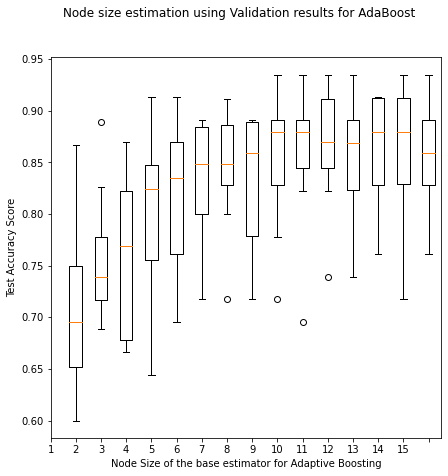

In [31]:
fig = plt.figure(figsize=(7,7))
fig.suptitle('Node size estimation using Validation results for AdaBoost')
plt.xlabel("Node Size of the base estimator for Adaptive Boosting")
plt.boxplot(results_ab)
plt.ylabel("Test Accuracy Score")
plt.xticks(np.arange( 0, 16, 1.0))
plt.show()

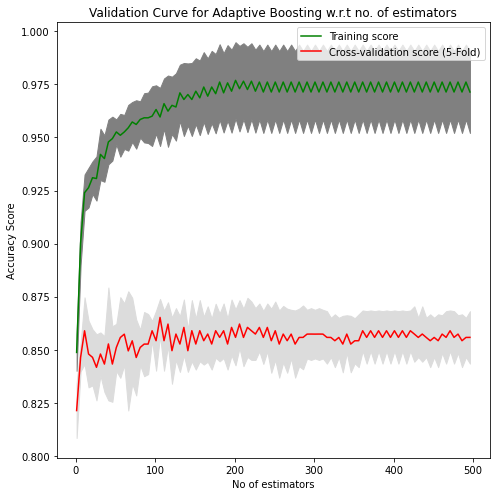

Wall time: 56 s


In [28]:
%%time
# Create range of values for the hyperparameter
param_range= np.arange(1, 500, 5)
# Calculate accuracy on training and test data set through cross validation (on entire dataset, since sample size is small)
base_estimator = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=11, criterion= "entropy", random_state=0)
classifier = AdaBoostClassifier(base_estimator= base_estimator, learning_rate= 0.4, algorithm= "SAMME", random_state=0)
classifier.fit(X_train, y_train)
#y_pred = classifier.predict(X_test)
train_scores, test_scores = validation_curve(classifier, X_train, y_train, 
                                             param_name="n_estimators", param_range=param_range, 
                                             cv=5, scoring="accuracy", n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score (5-Fold)", color="red")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve for Adaptive Boosting w.r.t no. of estimators")
plt.xlabel("No of estimators")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [71]:
%%time
# Create range of values for the hyperparameter
param_range= np.arange(0.0001, 1, 0.005)
# Calculate accuracy on training and test data set through cross validation (on entire dataset, since sample size is small)
base_estimator = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=11, criterion= "entropy", random_state=0)
classifier = AdaBoostClassifier(base_estimator= base_estimator,n_estimators=1000, algorithm= "SAMME", random_state=0)
classifier.fit(X_train, y_train)
#y_pred = classifier.predict(X_test)
train_scores, test_scores = validation_curve(classifier, X_train, y_train, 
                                             param_name="learning_rate", param_range=param_range, 
                                             cv=5, scoring="accuracy", n_jobs=8)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Wall time: 11min 41s


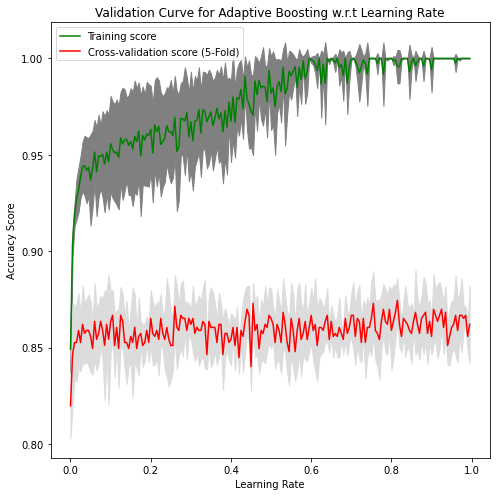

In [72]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score (5-Fold)", color="red")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve for Adaptive Boosting w.r.t Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [73]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [74]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0, test_size=0.1)

In [141]:
from sklearn.pipeline import Pipeline
base_estimator = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=11, criterion= "entropy", random_state=0)
classifier = AdaBoostClassifier(base_estimator= base_estimator, algorithm= "SAMME", random_state=0)

model_adabst = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", classifier),
])


In [76]:
from sklearn import set_config
set_config(display='diagram')
model_adabst

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   'ecorc...
                                                   'port_arbre',
                                                   'vigueur_pousse',
                                                   'champignon_collet',
                                                   'plaie_collet',
                                                   'champignon_tronc',
                                                   'fissure_tronc',
                                                   'rejet_tronc',
                                                   'tuteurage_arbre',
                                                   'canisse_arbre',
                                                   'plaie_tronc',
                                                   'champignon_houppier'])])),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=4,
                                                                          max_leaf_nodes=10,
                                                                          random_state=0),
                                    random_state=0))])

In [132]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__n_estimators': loguniform_int(250, 1000),
    'classifier__learning_rate': loguniform(0.1, 0.6),
}

model_random_search_adabst = RandomizedSearchCV(
    model_adabst, param_distributions=param_distributions, n_iter=500,
    cv=5, verbose=1, random_state =0, n_jobs=-1,
)
model_random_search_adabst.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Wall time: 17min 34s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['quartier',
                                                                                'site',
                                                                                'cote_voirie',
                                                                                'contrainte',
                                                                                'genre_arbre',
                                                                                'espece_arbre',
                                                                                'situation',
                                                                                'type_sol',
                                                                                'plaie_houppier',
                                                                                'bois_...
                                                                 base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                                       max_depth=4,
                                                                                                       max_leaf_nodes=10,
                                                                                                       random_state=0),
                                                                 random_state=0))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D6D33A2700>,
                                        'classifier__n_estimators': <__main__.loguniform_int object at 0x000001D6D487E8B0>},
                   random_state=0, verbose=1)

In [133]:
accuracy = model_random_search_adabst.score(X_test, y_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.86


In [134]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search_adabst.best_params_)

The best parameters are:
{'classifier__learning_rate': 0.5794816078118836,
 'classifier__n_estimators': 837}



We can inspect the results using the attributes `cv_results` as we did
previously.

In [1]:
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search_adabst.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results.head(100)

NameError: name 'param_distributions' is not defined

In [136]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,n_estimators,learning_rate,mean_test_score,std_test_score,rank_test_score
281,837,0.579482,0.873031,0.009233,1
443,693,0.397975,0.871481,0.009276,2
384,749,0.564688,0.869906,0.012713,3
473,398,0.36241,0.869894,0.015416,4
143,485,0.58078,0.869882,0.012974,5
...,...,...,...,...,...
351,281,0.115522,0.838558,0.014479,495
309,998,0.203763,0.837057,0.021329,497
276,514,0.220786,0.837008,0.023294,498
447,498,0.304343,0.837008,0.016555,499


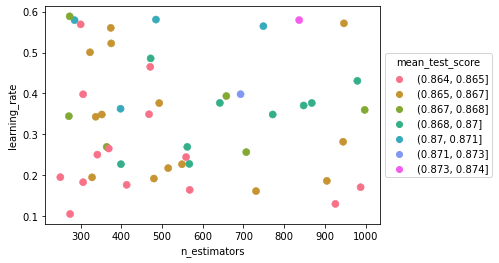

In [140]:
import seaborn as sns

df_tuning = pd.DataFrame(
    {
        "n_estimators": cv_results["n_estimators"],
        "learning_rate": cv_results["learning_rate"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.863620, 0.874, 8)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df_tuning,
    x="n_estimators",
    y="learning_rate",
    hue="score_bin",
    s=50,
    color="k",
    edgecolor=None,
)
#ax.set_xscale("log")
#ax.set_yscale("log")

_ = ax.legend(title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5))